# Cradlepoint vs Probe Analysis
### Author: Jeff Li, SIPS
#### Jeffrey.Li45@T-Mobile.com

Purpose: The purpose of this notebook is to evaluate whether or not the speedtests from Cradlepoints in the back of house of retail stores can be used as a substitute for the probe Galaxy S9s. We will be comparing aggregated Cradlepoint speed test data against aggregated probe s9 data.

Summary: Cradlepoints speed tests from back of house do not make a good substitute for speed tests from the S9 phones in front of house.

Data Sources:

removed
removed

In [337]:
#Import Python Packages for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

##Set options to display columns nicely
pd.set_option('display.max_columns',8)
pd.set_option('display.width', 200)

## Data Exploration & Data Processing

In [339]:
############Process Data############

#####Import probe data#####

df_probe = pd.read_csv('ProbeData2.csv', sep=',') #read csv
df_probe['SAPID'] = df_probe['Store ID'].str[4:] #slice SAP
df_probe['Download_probe'] = df_probe['Download'] #refactor column name
df_probe['Upload_probe'] = df_probe['Upload'] #refactor column name
df_probe = df_probe[df_probe['Technology'] != 'WiFi'] #filter out speed tests with Wifi

#filter on bands

#B66 between(66436,67335)
#B2 between(600,1199)
#B12 between (5010,5179)
#B71 between (68586, 68935)
#B4 between (1950, 2399)

def band_assign(df):
    if 66436 <= df['EARFCN'] <= 67335:
        return 66
    elif 600 <= df['EARFCN'] <= 1199:
        return 2
    elif 5010 <= df['EARFCN'] <= 5179:
        return 12
    elif 68586 <= df['EARFCN'] <= 68935:
        return 71
    elif 1950 <= df['EARFCN'] <= 2399:
        return 4
    else:
        return None
    
df_probe['band'] = df_probe.apply(band_assign, axis = 1)

#####Import cradlepoint data######
df_cradlepoint = pd.read_csv ('cradlepoint_export_2019-10-14.csv', sep=',')

#Extract Hostname, SAP fields, device type, and band
df_cradlepoint['Hostname'] = df_cradlepoint['Device name / description'].str.slice(0,8)
df_cradlepoint['SAPID'] = df_cradlepoint['Hostname'].str.slice(4,8)
df_cradlepoint['CP_device_type'] = df_cradlepoint['Group'].str.slice(0,5)
df_cradlepoint['band'] = df_cradlepoint['Service type'].str.extract('(\d+)')

#filter out where 'no data is blank'
df_cradlepoint = df_cradlepoint[df_cradlepoint['speed down'] != 'no data']
df_cradlepoint = df_cradlepoint[df_cradlepoint['speed up'] != 'no data']
#df_cradlepoint = df_cradlepoint.filter(items=[])

#Remove mbps from speed fields and cast as float
df_cradlepoint['Upload_CP'] = df_cradlepoint['speed up'].str.replace(r'[A-Za-z\s]', '').astype('float')
df_cradlepoint['Download_CP'] = df_cradlepoint['speed down'].str.replace(r'[A-Za-z\s]', '').astype('float')

#Print what bands are present in our dataset
print('Distinct cradlepoint bands: ' + str(np.unique(df_cradlepoint['band'])))
print('Distinct probe bands: ' + str(df_probe['band'].unique()))


Distinct cradlepoint bands: ['4']
Distinct probe bands: [66.  2.  4. nan 12. 71.]


Note that only band 4 is present in the Cradlepoint data, but there are multiple bands present in the probe. For the sake of comparison, we will only be running our analysis on band 4.

In [340]:
#filter df_probe_f
print('Number of individual probe speed tests = ' + str(len(df_probe.index)))
df_probe_f = df_probe[df_probe['band'] == 4]
df_probe_f = df_probe_f[['SAPID','Download_probe','Upload_probe','Ping','Jitter','Date','EARFCN']]
#print(df_probe_f.sort_values(by=['SAPID','Date']))
df_probe_f = df_probe_f[['SAPID','Download_probe','Upload_probe','Ping','Jitter','Date']]
print('Number of individual probe speed tests after filtering on band 4 = ' + str(len(df_probe_f.index)))

#aggregate on SAP and get mean
df_probe_f_agg = df_probe_f.groupby(['SAPID']).mean() 

#Join data from both tests
df_comb = pd.merge(df_probe_f_agg, df_cradlepoint, on='SAPID', how='inner')

#select columns in question
#df_comb = df_comb.filter(items=['SAPID','Download_probe','Upload_probe','Download_CP','Upload_CP','CP_device_type','EARFCN'])
df_comb = df_comb.filter(items=['SAPID','ID','Download_probe','Upload_probe','Download_CP','Upload_CP','CP_device_type'])

#print(df_comb)
#print(df_comb['ID'].tolist())



Number of individual probe speed tests = 142799
Number of individual probe speed tests after filtering on band 4 = 20446


Now that we've processed the data, let's visualize the data below.

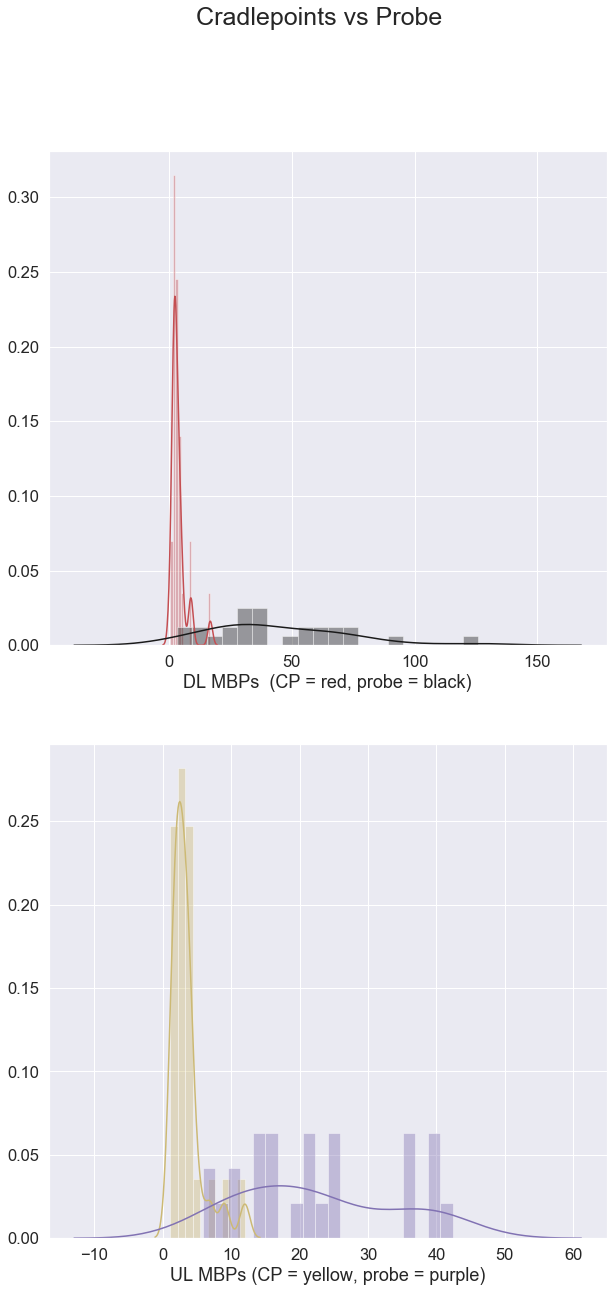

In [335]:
from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10, 20

download_cp = df_comb['Download_CP'].tolist()
upload_cp = df_comb['Upload_CP'].tolist()
download_probe = df_comb['Download_probe'].tolist()
upload_probe = df_comb['Upload_probe'].tolist()
#print(x)
fig = plt.figure()

fig.suptitle('Cradlepoints vs Probe', fontsize = 25)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)
ax4 = fig.add_subplot(212)

sns.set(color_codes=True,
       font_scale = 1.5)

sns.distplot(download_cp, 
             color = "r",
             axlabel = "DL MBPs  (CP = red, probe = black)",
             bins=15, 
             ax=ax1)

sns.distplot(download_probe, 
             bins=20,
             color = "k",
             #axlabel = "Probe DL MBPs",
             ax=ax2)

sns.distplot(upload_cp, 
             bins=10, 
             color = "y",
             axlabel = "UL MBPs (CP = yellow, probe = purple)",
             ax=ax3)

sns.distplot(upload_probe, 
             bins=20,
             color = "m",
             #axlabel = "Probe UL MBPs",
             ax=ax4)

We can see that the distribution of the Cradlepoints and Probes for download and uploads are drastically different. This makes sense since Cradlepoints are back of house and the probe phones are front of house.

## Statistical Test & Evaluation

We will be using the Wilcoxon Signed Rank test in order to compare the speed tests of the 2 subsets of devices. Why does this make sense?

According to Wikipedia: The Wilcoxon signed-rank test is a non-parametric statistical hypothesis test used to compare two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ (i.e. it is a paired difference test).

Why is the Wilcoxon test appropriate?

1) Our data does not need to be normally distributed (a common assumption of many statistical tests).

2) The speed tests will be ranked for each store by cradlepoint/probe, and the ranks will be compared against eachother. Although speeds for probe & Cradlepoints both are measured in MBPs, there are multiple confounding factors (frequency/methodolgy of speed test, how Cradlepoint was measured). Location of probes and Cradlepoints are also in different places of the store. A dependent t-test might be more appropriate if these confounding factors weren't there. Since these confounding factors are part of the problem at hand, the Wilcoxon signed-rank test is more appropriate in this instance.

Our null hypothesis is that the distribution of download speeds (or upload speeds) of Cradlepoint and probe are the same for both groups.

Our alternative hypothesis is that the distribution of download speeds ranks (or upload speeds) of Cradlepoint and probe are different.

-------



Some additional resources (if you want to read a little more into the topic):

https://stats.stackexchange.com/questions/238633/wilcoxon-rank-sum-mann-whitney-test-sas-results-interpretation

https://www.stat.auckland.ac.nz/~wild/ChanceEnc/Ch10.wilcoxon.pdf


--------

With that said, let's go ahead and run the Wilcoxon signed rank test....


In [290]:
print(stats.wilcoxon(df_comb['Download_CP'],df_comb['Download_probe']))
print(stats.wilcoxon(df_comb['Upload_CP'],df_comb['Upload_probe']))

WilcoxonResult(statistic=0.0, pvalue=5.5719648223844e-17)
WilcoxonResult(statistic=9.0, pvalue=7.462863988798968e-17)


Our p-values are extremely low here - as a result, we reject the null - the distribution of download speeds ranks (or upload speeds) of Cradlepoint and probe are different. The speed test ranks of Cradlepoints do not make a good substitute for the speed test ranks of the probes.